In [6]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import hvplot.pandas

np.random.seed(42)

In [7]:
pd.options.display.max_columns = 999

# Exercise on Predictive modeling: Housing price modeling

- **Focus**: much more hands-on experience with featuring engineering and adding spatial based features

### Recap

- An introduction to supervised learning and regression with scikit learn
- **Key concepts:**
    - Linear regression
    - Ridge regression with regularization 
    - Test/train split and k-fold cross validation
    - Feature engineering
        - Scaling input features
        - Adding polynomial features
    - Decision trees and random forests

First, let's setup all of the imports we'll need from scikit learn:

In [8]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Pipelines
from sklearn.pipeline import make_pipeline

# Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# **Predicting housing prices in Philadelphia**

### Load data from the Office of Property Assessment

Let's download data for **single-family** properties in Philadelphia that had their **last sale during 2022.**

- [Metadata](http://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/)

Download the raw sales data:

In [9]:
# the CARTO API url
carto_url = "https://phl.carto.com/api/v2/sql"

# Only pull 2022 sales for single family residential properties
where = "sale_date >= '2022-01-01' and sale_date <= '2022-12-31'"
where = where + " and category_code_description IN ('SINGLE FAMILY', 'Single Family')"

# Create the query
query = f"SELECT * FROM opa_properties_public WHERE {where}"

# Make the request
params = {"q": query, "format": "geojson"}
response = requests.get(carto_url, params=params)

Convert to a GeoDataFrame:

In [10]:
# Make the GeoDataFrame
salesRaw = gpd.GeoDataFrame.from_features(response.json(), crs="EPSG:4326")

# Optional: put it a reproducible order for test/training splits later
salesRaw = salesRaw.sort_values("parcel_number")

In [11]:
salesRaw.head()

,geometry,cartodb_id,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,census_tract,central_air,cross_reference,date_exterior_condition,depth,exempt_building,exempt_land,exterior_condition,fireplaces,frontage,fuel,garage_spaces,garage_type,general_construction,geographic_ward,homestead_exemption,house_extension,house_number,interior_condition,location,mailing_address_1,mailing_address_2,mailing_care_of,mailing_city_state,mailing_street,mailing_zip,market_value,market_value_date,number_of_bathrooms,number_of_bedrooms,number_of_rooms,number_stories,off_street_open,other_building,owner_1,owner_2,parcel_number,parcel_shape,quality_grade,recording_date,registry_number,sale_date,sale_price,separate_utilities,sewer,site_type,state_code,street_code,street_designation,street_direction,street_name,suffix,taxable_building,taxable_land,topography,total_area,total_livable_area,type_heater,unfinished,unit,utility,view_type,year_built,year_built_estimate,zip_code,zoning,pin,building_code_new,building_code_description_new,objectid
10793,POINT (-75.14926 39.92699),37300,2024-06-06T16:13:05Z,A,N W C MORRIS,54134182,BB0,STR/OFF 2 STY MASONRY,1,SINGLE FAMILY,27,Y,None,None,48.0,0.0,0.0,1,NaN,18.0,A,2.0,1,B,1,0,None,1632,1,1632 S 2ND ST,URBAN REAL ESTATE INVESTMENT INC,None,None,WEST POINT PA,None,19486,825000.0,None,NaN,4.0,7.0,3.0,816.0,None,URBAN REAL ESTATE INVESTMENT INC,None,011000029,A,None,2022-12-23T05:00:00Z,012S080034,2022-12-07T05:00:00Z,1.0,None,None,None,PA,87840,ST,S,2ND,None,660000.0,165000.0,F,1079.0,2790.0,A,None,None,None,I,2024,None,19148,CMX1,1001684829,25,ROW MODERN,546728114
10790,POINT (-75.14928 39.92693),37297,2024-06-06T16:13:04Z,A,N W C MORRIS,54134182,BB0,STR/OFF 2 STY MASONRY,1,SINGLE FAMILY,27,Y,None,None,48.0,0.0,0.0,1,NaN,20.0,A,2.0,1,B,1,0,None,1634,1,1634 S 2ND ST,URBAN REAL ESTATE INVESTMENT INC,None,None,WEST POINT PA,None,19486,825000.0,None,NaN,4.0,7.0,3.0,816.0,None,URBAN REAL ESTATE INVESTMENT INC,None,011000030,A,None,2022-12-23T05:00:00Z,012S080034,2022-12-07T05:00:00Z,1.0,None,None,None,PA,87840,ST,S,2ND,None,660000.0,165000.0,F,987.0,2580.0,A,None,None,None,I,2024,None,19148,CMX1,1001684830,25,ROW MODERN,546728111
10791,POINT (-75.14930 39.92687),37298,2024-06-06T16:13:04Z,A,N W C MORRIS,54134182,BB0,STR/OFF 2 STY MASONRY,1,SINGLE FAMILY,27,Y,None,None,48.0,0.0,0.0,1,NaN,20.0,A,2.0,1,B,1,0,None,1636,1,1636 S 2ND ST,URBAN REAL ESTATE INVESTMENT INC,None,None,WEST POINT PA,None,19486,825000.0,None,NaN,4.0,7.0,3.0,816.0,None,URBAN REAL ESTATE INVESTMENT INC,None,011000031,A,None,2022-12-23T05:00:00Z,012S080034,2022-12-07T05:00:00Z,1.0,None,None,None,PA,87840,ST,S,2ND,None,660000.0,165000.0,F,985.0,2580.0,A,None,None,None,I,2024,None,19148,CMX1,1001684831,25,ROW MODERN,546728112
10792,POINT (-75.14932 39.92682),37299,2024-06-06T16:13:04Z,A,N W C MORRIS,54134182,BB0,STR/OFF 2 STY MASONRY,1,SINGLE FAMILY,27,Y,None,None,47.0,0.0,0.0,1,NaN,19.0,A,2.0,1,B,1,0,None,1638,1,1638 S 2ND ST,URBAN REAL ESTATE INVESTMENT INC,None,None,WEST POINT PA,None,19486,825000.0,None,NaN,4.0,7.0,3.0,816.0,None,URBAN REAL ESTATE INVESTMENT INC,None,011000032,A,None,2022-12-23T05:00:00Z,012S080034,2022-12-07T05:00:00Z,1.0,None,None,None,PA,87840,ST,S,2ND,None,660000.0,165000.0,F,1050.0,2655.0,A,None,None,None,I,2024,None,19148,CMX1,1001684832,25,ROW MODERN,546728113
2587,POINT (-75.14860 39.93145),40763,2024-06-06T16:14:12Z,0,"36'6"" E OF AMERICAN",54131081,R30,ROW B/GAR 2 STY MASONRY,1,SINGLE FAMILY,27,Y,None,None,90.0,0.0,0.0,4,0.0,18.0,None,1.0,None,A,1,0,None,224,4,224 WHARTON ST,SIMPLIFILE LC E-RECORDING,None,None,PHILADELPHIA PA,224 WHARTON ST,19147-5336,463000.0,None,2.0,3.0,NaN,3.0,711.0,None,DEVER CATHERINE JOAN,None,011001670,E,C,2022-12-14T05:00:00Z,9S17 307,2022-12-05T05:00:00Z,450000.0,None,None,None,PA,82740,ST,None,WHARTON,None,370400.0,92600.0,F,1625.0,1785.0,A,None,None,None,I,1960,Y,19147,RSA5,1001563093,26,ROW RIVER ROW,546728798

In [12]:
len(salesRaw)

25341

Get the feature sales data we will work with:

In [13]:
# The feature columns we want to use
cols = [
    "sale_price",
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "exterior_condition",
    "zip_code",
]

# Trim to these columns and remove NaNs
sales = salesRaw[cols + ["geometry"]].dropna()

# Trim zip code to only the first five digits
sales["zip_code"] = sales["zip_code"].astype(str).str.slice(0, 5)

In [14]:
# Trim very low and very high sales
valid = (sales['sale_price'] > 3000) & (sales['sale_price'] < 1e6)
sales = sales.loc[valid]

In [15]:
len(sales)

17763

### Let's focus on numerical features only first

Split the data into a training and test set:

In [16]:
# Split the data 70/30
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

Get the predictive variable: log of sale price:

In [17]:
# the target labels: log of sale price
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

Get the features (numerical only first):

In [36]:
# The features
feature_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
]
X_train = train_set[feature_cols].values
X_test = test_set[feature_cols].values

Run a linear regression model as a baseline:

In [37]:
# Make a linear model pipeline
linear_pipeline = make_pipeline(StandardScaler(), LinearRegression())

# Fit on the training data
linear_pipeline.fit(X_train, y_train)

# What's the test score?
linear_pipeline.score(X_test, y_test)

0.2419607110573766

Run cross-validation on a random forest model:

In [38]:
# Make a random forest pipeline
forest_pipeline = make_pipeline(
    StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42)
)

# Run the 10-fold cross validation
scores = cross_val_score(
    forest_pipeline,
    X_train,
    y_train,
    cv=10,
)

# Report
print("R^2 scores = ", scores)
print("Scores mean = ", scores.mean())
print("Score std dev = ", scores.std())

R^2 scores =  [0.30995092 0.28818986 0.36937888 0.30434428 0.27947637 0.35309447
 0.26389992 0.32675176 0.36945254 0.33811781]
Scores mean =  0.32026568027693253
Score std dev =  0.03535471961459312


In [39]:
# Fit on the training data
forest_pipeline.fit(X_train, y_train)

# What's the test score?
forest_pipeline.score(X_test, y_test)

0.3714970113824225

### Which variables were most important?

In [40]:
# Extract the regressor from the pipeline
forest_model = forest_pipeline["randomforestregressor"]

In [41]:
# Create the data frame of importances
importance = pd.DataFrame(
    {"Feature": feature_cols, "Importance": forest_model.feature_importances_}
).sort_values("Importance")


importance.hvplot.barh(x="Feature", y="Importance")

:Bars   [Feature]   (Importance)

## How to handle categorical data?

We can use a technique called **one-hot encoding**
<br>
example here: ZIP code

**Steps**:
- Create a new column for each category
- Represent each category as a vector of 1s and 0s

<img src="imgs/one-hot.png" width=600></img>

## One-hot encoding in scikit learn

- The [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) object is a preprocessor that will perform the vectorization step
- The [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) object will help us apply different transformers to numerical and categorical columns

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

Let's try out the example data of colors:

In [26]:
# Example data of colors
colors = np.array(["red", "green", "blue", "red"])
colors = colors[:, np.newaxis]

In [27]:
colors.shape

(4, 1)

In [28]:
colors

array([['red'],
       ['green'],
       ['blue'],
       ['red']], dtype='<U5')

In [29]:
# Initialize the OHE transformer
ohe = OneHotEncoder()

# Fit the transformer and then transform the colors 
ohe.fit_transform(colors).toarray()

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [30]:
# The corresponding category for each column
ohe.categories_

[array(['blue', 'green', 'red'], dtype='<U5')]

Let's apply **separate** transformers for our numerical and categorical columns:

In [43]:
# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
]

# Categorical columns
cat_cols = ["exterior_condition", "zip_code"]

In [44]:
# Set up the column transformer with two transformers
# ----> Scale the numerical columns
# ----> One-hot encode the categorical columns

transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

**Note:** the `handle_unknown='ignore'` parameter ensures that if categories show up in our training set, but not our test set, no error will be raised.

Initialize the pipeline object, using the column transformer and the random forest regressor

In [48]:
# Initialize the pipeline
# NOTE: only use 10 estimators here so it will run in a reasonable time
pipe = make_pipeline(
    transformer, RandomForestRegressor(n_estimators=30, 
                                       random_state=42)
)

Now, let's fit the model.

### **Important!**

- You must **pass in the full training set and test set DataFrames**: `train_set` and `test_set`
- No need to create the `X_train` and `X_test` numpy arrays. 
- We told scikit learn which column strings to extract in the ColumnTransformer, so it needs the DataFrame with named columns.

In [49]:
# Fit the training set
pipe.fit(train_set, y_train);

In [50]:
# What's the test score?
pipe.score(test_set, y_test)

0.5687023191225087

### Substantial improvement on test set when including ZIP codes

R-squared of ~0.30 improved to R-squared of ~0.54!

**Takeaway:** neighborhood based effects play a crucial role in determining housing prices.

**Side Note:** to fully validate the model we should run k-fold cross validation and optimize hyperparameters of the model as well...


### But how crucial? Let's plot the importances


But first, we need to know the column names! The one-hot encoder created a column for each category type...

In [30]:
# The column transformer...
transformer

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['total_livable_area', 'total_area',
                                  'garage_spaces', 'fireplaces',
                                  'number_of_bathrooms', 'number_of_bedrooms',
                                  'number_stories']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['exterior_condition', 'zip_code'])])

In [51]:
# The steps in the column transformer
transformer.named_transformers_

{'num': StandardScaler(),
 'cat': OneHotEncoder(handle_unknown='ignore'),
 'remainder': 'drop'}

In [52]:
# The one-hot step
ohe = transformer.named_transformers_['cat']

ohe

OneHotEncoder(handle_unknown='ignore')

In [53]:
# One column for each category type!
ohe_cols = ohe.get_feature_names_out()

ohe_cols

array(['exterior_condition_0', 'exterior_condition_1',
       'exterior_condition_2', 'exterior_condition_3',
       'exterior_condition_4', 'exterior_condition_5',
       'exterior_condition_6', 'exterior_condition_7', 'zip_code_19102',
       'zip_code_19103', 'zip_code_19104', 'zip_code_19106',
       'zip_code_19107', 'zip_code_19111', 'zip_code_19114',
       'zip_code_19115', 'zip_code_19116', 'zip_code_19118',
       'zip_code_19119', 'zip_code_19120', 'zip_code_19121',
       'zip_code_19122', 'zip_code_19123', 'zip_code_19124',
       'zip_code_19125', 'zip_code_19126', 'zip_code_19127',
       'zip_code_19128', 'zip_code_19129', 'zip_code_19130',
       'zip_code_19131', 'zip_code_19132', 'zip_code_19133',
       'zip_code_19134', 'zip_code_19135', 'zip_code_19136',
       'zip_code_19137', 'zip_code_19138', 'zip_code_19139',
       'zip_code_19140', 'zip_code_19141', 'zip_code_19142',
       'zip_code_19143', 'zip_code_19144', 'zip_code_19145',
       'zip_code_19146', 'zip_

In [54]:
# Full list of columns is numerical + one-hot 
features = num_cols + list(ohe_cols)

features

['total_livable_area',
 'total_area',
 'garage_spaces',
 'fireplaces',
 'number_of_bathrooms',
 'number_of_bedrooms',
 'number_stories',
 'exterior_condition_0',
 'exterior_condition_1',
 'exterior_condition_2',
 'exterior_condition_3',
 'exterior_condition_4',
 'exterior_condition_5',
 'exterior_condition_6',
 'exterior_condition_7',
 'zip_code_19102',
 'zip_code_19103',
 'zip_code_19104',
 'zip_code_19106',
 'zip_code_19107',
 'zip_code_19111',
 'zip_code_19114',
 'zip_code_19115',
 'zip_code_19116',
 'zip_code_19118',
 'zip_code_19119',
 'zip_code_19120',
 'zip_code_19121',
 'zip_code_19122',
 'zip_code_19123',
 'zip_code_19124',
 'zip_code_19125',
 'zip_code_19126',
 'zip_code_19127',
 'zip_code_19128',
 'zip_code_19129',
 'zip_code_19130',
 'zip_code_19131',
 'zip_code_19132',
 'zip_code_19133',
 'zip_code_19134',
 'zip_code_19135',
 'zip_code_19136',
 'zip_code_19137',
 'zip_code_19138',
 'zip_code_19139',
 'zip_code_19140',
 'zip_code_19141',
 'zip_code_19142',
 'zip_code_19143'

In [55]:
random_forest = pipe["randomforestregressor"]

# Create the dataframe with importances
importance = pd.DataFrame(
    {"Feature": features, "Importance": random_forest.feature_importances_}
)

In [36]:
importance.head(n=20)

,Feature,Importance
0,total_livable_area,0.177882
1,total_area,0.231340
2,garage_spaces,0.010044
3,fireplaces,0.001861
4,number_of_bathrooms,0.161817
5,number_of_bedrooms,0.052586
6,number_stories,0.022008
7,exterior_condition_0,0.000013
8,exterior_condition_1,0.001369
9,exterior_condition_2,0.004490


In [56]:
# Sort by importance and get the top 30
# SORT IN DESCENDING ORDER
importance = importance.sort_values("Importance", ascending=False).iloc[:30]

# Plot
importance.hvplot.barh(x="Feature", y="Importance", height=700, flip_yaxis=True)

:Bars   [Feature]   (Importance)

### Takeaways

- Number of bathrooms and area-based features still important
- ZIP codes in North Philadelphia also important: 19140, 19132, 19134

**Interpretation**

These North Philadelphia ZIP codes have some of the lowest valued homes in the city, which are inherently the most difficult to model accurately. It makes sense when included ZIP code information that these areas would be the most to improve. 

## Why is feature engineering so important?

**Garbage in, garbage out**

- What we're trying to do is build the best possible model for a particular thing we care about, e.g., housing price, bikeshare trips, etc
- Our machine learning models try to translate from some set of input features to the thing we care about
- You should think of the input features as having *all of the same information* as the predicted quantity — *they are just a different representation*

**Takeway:** If your input features are poorly designed (for example, completely unrelated to thing you want to predict), then no matter how good your machine learning model is or how well you "train" it, then the model will never be able to do the translation from features to predicted value.

## Adding spatial features to the housing price model

- Adding in ZIP code information captures a lot of the neighborhood-based amenity/disamenity properties
- Can we explicitly add new features that also try to capture some of those features?

**Yes, let's add distance-based features**

## Spatial amenity/disamenity features

**The strategy**

- Get the data for a certain type of amenity, e.g., restaurants, bars, or disamenity, e.g., crimes
    - Data sources: 311 requests, crime incidents, Open Street Map
- Use scikit learn's nearest neighbor algorithm to calculate the distance from each sale to its nearest neighbor in the amenity/disamenity datasets

## Examples of new possible features...

Distance from each sale to:

- Universities
- Parks
- City Hall
- Subway Stops
- New Construction Permits
- Aggravated Assaults
- Graffiti 311 Calls
- Abandoned Vehicle 311 Calls

### Example #1: 311 Graffiti Calls

Source: [https://www.opendataphilly.org/dataset/311-service-and-information-requests](https://www.opendataphilly.org/dataset/311-service-and-information-requests)

[Metadata](https://metadata.phila.gov/#home/datasetdetails/5543864d20583086178c4e98/representationdetails/5762e19fa237544b2ecfe722/)

#### Step 1: Download the data from the CARTO database


We'll only pull data from 2022.

Let's make a utility function to download data for a specific table and where statement from CARTO:

In [57]:
def get_carto_data(table_name, where=None, limit=None):
    """
    Download data from CARTO given a specific table name and
    optionally a where statement or limit.
    """

    # the CARTO API url
    carto_url = "https://phl.carto.com/api/v2/sql"

    # Create the query
    query = f"SELECT * FROM {table_name}"

    # Add a where
    if where is not None:
        query = query + f" WHERE {where}"

    # Add a limit
    if limit is not None:
        query = query + f" LIMIT {limit}"

    # Make the request
    params = {"q": query, "format": "geojson"}
    response = requests.get(carto_url, params=params)

    # Make the GeoDataFrame
    return gpd.GeoDataFrame.from_features(response.json(), crs="EPSG:4326")

Let's take a peak at the first row:

In [58]:
# the 311 table
table_name = "public_cases_fc"

get_carto_data(table_name, limit=1)

,geometry,cartodb_id,objectid,service_request_id,subject,status,status_notes,service_name,service_code,agency_responsible,service_notice,requested_datetime,updated_datetime,expected_datetime,closed_datetime,address,zipcode,media_url,lat,lon
0,POINT (-75.15416 39.96156),1,1,1960,Street Light Outage,Closed,Other,Street Light Outage,SR-ST04,Streets Department,None,2014-05-23T13:23:57Z,2024-05-10T18:43:50Z,2014-06-09T00:00:00Z,2017-06-07T18:10:04Z,990 SPRING GARDEN ST,19123,None,39.961564,-75.154156


Let's build our where clause based on the 'requested_datetime'

In [65]:
# Select only those for grafitti and in 2022
where = "requested_datetime >= '01-01-2022' and requested_datetime < '01-01-2023'"
where = where + " and service_name = 'Graffiti Removal'"

# Pull the subset we want
graffiti = get_carto_data(table_name, where=where)

In [66]:
# Remove rows with empty or NaN geometries
not_missing = (~graffiti.geometry.is_empty) & (graffiti.geometry.notna())
graffiti = graffiti.loc[not_missing]

In [67]:
len(graffiti)

16281

In [62]:
graffiti.head()

,geometry,cartodb_id,objectid,service_request_id,subject,status,status_notes,service_name,service_code,agency_responsible,service_notice,requested_datetime,updated_datetime,expected_datetime,closed_datetime,address,zipcode,media_url,lat,lon
0,POINT (-75.14570 39.95761),4038081,4044086,14650458,Graffiti Removal,Closed,Issue Resolved,Graffiti Removal,SR-CL01,Community Life Improvement Program,7 Business Days,2022-01-03T23:03:07Z,2024-05-11T00:44:42Z,2022-01-13T00:00:00Z,2022-01-07T13:30:02Z,CALLOWHILL ST & N 4TH ST,19123,https://d17aqltn7cihbm.cloudfront.net/uploads/...,39.957610,-75.145700
1,POINT (-75.22123 39.97351),4038092,4044098,14650473,Graffiti Removal,Closed,Issue Resolved,Graffiti Removal,SR-CL01,Community Life Improvement Program,7 Business Days,2022-01-03T23:19:26Z,2023-02-16T03:01:28Z,2022-01-13T00:00:00Z,2022-01-06T14:10:58Z,4945 W THOMPSON ST,19131,None,39.973507,-75.221235
2,POINT (-75.16333 39.94261),4038224,4044230,14650631,Graffiti Removal,Closed,Issue Resolved,Graffiti Removal,SR-CL01,Community Life Improvement Program,7 Business Days,2022-01-04T02:39:53Z,2023-02-16T02:54:49Z,2022-01-13T00:00:00Z,2022-01-06T13:48:15Z,629 S 13TH ST,19147,https://d17aqltn7cihbm.cloudfront.net/uploads/...,39.942605,-75.163325
3,POINT (-75.15956 39.94604),4038227,4044233,14650638,Graffiti Removal,Closed,Issue Resolved,Graffiti Removal,SR-CL01,Community Life Improvement Program,7 Business Days,2022-01-04T02:58:24Z,2023-02-16T03:02:18Z,2022-01-13T00:00:00Z,2022-01-06T14:05:01Z,304 S 10TH ST,19107,https://d17aqltn7cihbm.cloudfront.net/uploads/...,39.946044,-75.159564
4,POINT (-75.13272 39.99284),4038246,4044252,14650677,Graffiti Removal,Closed,Other,Graffiti Removal,SR-CL01,Community Life Improvement Program,7 Business Days,2022-01-04T09:32:56Z,2023-02-16T03:00:40Z,2022-01-13T00:00:00Z,2022-01-04T14:06:36Z,2800 MASCHER ST,19133,None,39.992840,-75.132723


#### Step 2: Get the x/y coordinates of both datasets

We will need to:

- We'll want distances in meters (rather than degrees), so we'll convert the CRS to EPSG=3857
- Extract out the x/y coordinates of the geometry column of each dataset (sales and grafitti calls)

In [68]:
# Do the CRS conversion
sales_3857 = sales.to_crs(epsg=3857)
graffiti_3857 = graffiti.to_crs(epsg=3857)

In [69]:
def get_xy_from_geometry(df):
    """
    Return a numpy array with two columns, where the 
    first holds the `x` geometry coordinate and the second 
    column holds the `y` geometry coordinate
    """
    x = df.geometry.x
    y = df.geometry.y
    
    return np.column_stack((x, y)) # stack as columns

In [70]:
# Extract x/y for sales
salesXY = get_xy_from_geometry(sales_3857)

# Extract x/y for grafitti calls
graffitiXY = get_xy_from_geometry(graffiti_3857)

In [71]:
salesXY.shape

(17763, 2)

In [72]:
graffitiXY.shape

(16281, 2)

#### Step 3: Calculate the nearest neighbor distances

For this, we will use the k-nearest neighbors algorithm from scikit learn.

For each sale:
- Find the k-nearest neighbors in the second dataset (graffiti calls, crimes, etc)
- Calculate the average distance from the sale to those k-neighbors

In [73]:
from sklearn.neighbors import NearestNeighbors

In [74]:
# STEP 1: Initialize the algorithm
k = 5
nbrs = NearestNeighbors(n_neighbors=k)

# STEP 2: Fit the algorithm on the "neighbors" dataset
nbrs.fit(graffitiXY)

# STEP 3: Get distances for sale to neighbors
grafDists, grafIndices = nbrs.kneighbors(salesXY) 

**Note:** I am using `k=5` here without any real justification. In practice, you would want to try a few different k values to try to identify the best value to use.

#### What did we just calculate?

- `grafDists`: For each sale, the distances to the 5 nearest graffiti calls
    - This should have 5 columns and the same length as the sales dataset
- `grafIndices`: For each sale, the index of each of the 5 neighbors in the original dataset
    - This allows you to access the original 311 graffiti data

In [75]:
print("length of sales = ", len(salesXY))
print("shape of grafDists = ", grafDists.shape)
print("shape of grafIndices = ", grafIndices.shape)

length of sales =  17763
shape of grafDists =  (17763, 5)
shape of grafIndices =  (17763, 5)


In [76]:
# The distances from the first sale to the 5 nearest neighbors
grafDists[0]

array([ 74.69196533, 109.96264648, 132.79982755, 134.17262561,
       174.53660354])

In [77]:
grafIndices[0]

array([ 3816,  5779, 13408,  1139,  7146])

#### Can we reproduce these distances?

In [78]:
salesXY[0]

array([-8365504.33110536,  4855986.06521187])

In [79]:
# The coordinates for the first sale
x0, y0 = salesXY[0]
x0, y0

(-8365504.331105363, 4855986.065211866)

In [80]:
# The indices for the 5 nearest graffiti calls
grafIndices[0]

array([ 3816,  5779, 13408,  1139,  7146])

In [81]:
# the graffiti neighbors
sale0_neighbors = graffitiXY[grafIndices[0]]
sale0_neighbors

array([[-8365555.31543214,  4856040.64989935],
       [-8365425.62822537,  4856062.86130748],
       [-8365594.27725392,  4856083.76620754],
       [-8365636.57866042,  4856008.71201389],
       [-8365406.14731448,  4856130.36687223]])

In [82]:
# Access the first and second column for x/y values
neighbors_x = sale0_neighbors[:,0]
neighbors_y = sale0_neighbors[:,1]

# The x/y differences between neighbors and first sale coordinates
dx = (neighbors_x - x0)
dy = (neighbors_y - y0)

# The Euclidean dist
manual_dists = (dx**2 + dy**2) ** 0.5

In [83]:
manual_dists

array([ 74.69196533, 109.96264648, 132.79982755, 134.17262561,
       174.53660354])

In [84]:
grafDists[0]

array([ 74.69196533, 109.96264648, 132.79982755, 134.17262561,
       174.53660354])

#### Use the log of the average distance as the new feature

We'll average over the column axis: `axis=1`

In [85]:
grafDists.mean(axis=1)

array([125.2327337 , 164.21662169, 156.49823723, ..., 614.26510679,
       614.26510679, 614.26510679])

In [86]:
# Average distance to neighbors
avgGrafDist = grafDists.mean(axis=1)

# Set zero distances to be small, but nonzero
# IMPORTANT: THIS WILL AVOID INF DISTANCES WHEN DOING THE LOG
avgGrafDist[avgGrafDist==0] = 1e-5

# Calculate log of distances
sales['logDistGraffiti'] = np.log10(avgGrafDist)

In [87]:
sales.head()

,sale_price,total_livable_area,total_area,garage_spaces,fireplaces,number_of_bathrooms,number_of_bedrooms,number_stories,exterior_condition,zip_code,geometry,logDistGraffiti
2587,450000.0,1785.0,1625.0,1.0,0.0,2.0,3.0,3.0,4,19147,POINT (-75.14860 39.93145),2.097718
11836,670000.0,2244.0,1224.0,0.0,0.0,3.0,4.0,3.0,3,19147,POINT (-75.14817 39.93101),2.215417
9533,790000.0,2514.0,1400.0,1.0,0.0,0.0,3.0,2.0,3,19147,POINT (-75.14781 39.93010),2.194509
2192,195000.0,1358.0,840.0,0.0,0.0,2.0,3.0,3.0,4,19147,POINT (-75.14887 39.93026),2.212881
13305,331000.0,868.0,546.0,0.0,0.0,2.0,2.0,2.0,4,19147,POINT (-75.14881 39.93012),2.206706


#### Let's plot a hex map of the new feature!

In [88]:
# Load the City Limits from OpenDataPhilly's page
url = "https://opendata.arcgis.com/datasets/405ec3da942d4e20869d4e1449a2be48_0.geojson"
city_limits = gpd.read_file(url).to_crs(epsg=3857)

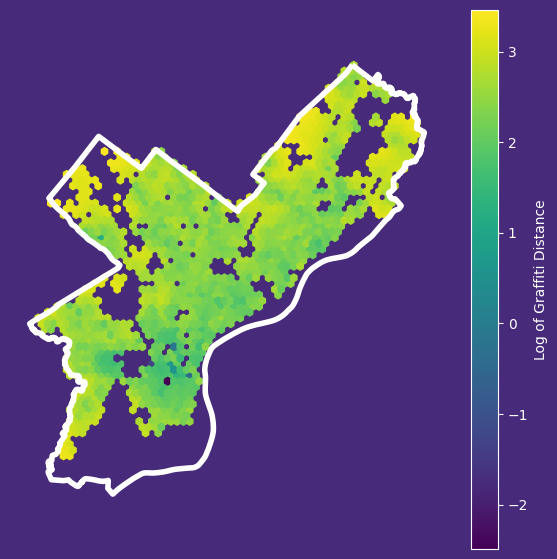

In [95]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 7), facecolor=plt.get_cmap("viridis")(30))

# Plot the log of the Graffiti distance
x = salesXY[:, 0]
y = salesXY[:, 1]
hb = ax.hexbin(x, y, C=sales["logDistGraffiti"].values, gridsize=60, cmap="viridis")

# Add color bar for the hexbin plot
cb = plt.colorbar(hb, ax=ax, orientation="vertical")
cb.set_label("Log of Graffiti Distance", color="white")  # Set colorbar label to white

# Change color of the colorbar ticks
cb.ax.yaxis.set_tick_params(color="white")  # Color of tick marks
cb.ax.yaxis.set_tick_params(labelcolor="white")  # Color of tick labels

# Change the spine color of the colorbar to white
cb.outline.set_edgecolor("white")

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

# Set axis off
ax.set_axis_off()
ax.set_aspect("equal")

plt.show()

### Example #2: Subway stops

Use the `osmnx` package to get subway stops in Philly — we can use the `ox.geometries_from_polygon()` function.

- To select subway stations, we can use `station=subway`: see the [OSM Wikipedia](https://wiki.openstreetmap.org/wiki/Tag:station%3Dsubway)
- See [Lecture 5A](https://musa-550-fall-2023.github.io/content/week-5/lecture-5A.html) for a reminder on osmnx!

In [96]:
import osmnx as ox

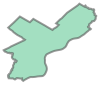

In [97]:
city_limits.to_crs(epsg=4326).squeeze().geometry

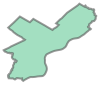

In [98]:
# Get the geometry from the city limits
city_limits_outline = city_limits.to_crs(epsg=4326).squeeze().geometry

city_limits_outline

In [100]:
# Get the subway stops within the city limits
subway = ox.features_from_polygon(city_limits_outline, tags={"station": "subway"})

# Convert to 3857 (meters)
subway = subway.to_crs(epsg=3857)

subway.head(n=10)

addr:city addr:state                name network  \
element_type osmid                                                            
node         469917297  Philadelphia         PA  15th-16th & Locust   PATCO   
             469917298  Philadelphia        NaN   9th-10th & Locust   PATCO   
             471026103  Philadelphia        NaN  12th-13th & Locust   PATCO   
             650938316           NaN        NaN         63rd Street   SEPTA   
             650959043           NaN        NaN         56th Street   SEPTA   
             650960111           NaN        NaN         46th Street     NaN   
             775915931  Philadelphia        NaN       Lombard-South   SEPTA   
             775915932           NaN        NaN   Ellsworth-Federal   SEPTA   
             775915933  Philadelphia        NaN       Tasker-Morris   SEPTA   
             775915935  Philadelphia        NaN              Snyder   SEPTA   

                       operator platforms public_transport  railway station  \
element_type osmid                                                            
node         469917297    PATCO         1          station  station  subway   
             469917298    PATCO         1          station  station  subway   
             471026103    PATCO         1          station  station  subway   
             650938316    SEPTA       NaN          station  station  subway   
             650959043    SEPTA       NaN          station  station  subway   
             650960111    SEPTA       NaN          station  station  subway   
             775915931    SEPTA         1          station  station  subway   
             775915932    SEPTA         1          station  station  subway   
             775915933    SEPTA         1          station  station  subway   
             775915935    SEPTA         1          station  station  subway   

                       subway wheelchair   wikidata  \
element_type osmid                                    
node         469917297    yes        yes   Q4551078   
             469917298    yes        yes   Q4646737   
             471026103    yes         no   Q4548965   
             650938316    yes        NaN        NaN   
             650959043    yes        NaN   Q4640769   
             650960111    yes        yes        NaN   
             775915931    yes         no   Q6669414   
             775915932    yes         no  Q11681426   
             775915933    yes         no   Q7687362   
             775915935    yes        NaN   Q7548885   

                                           wikipedia  \
element_type osmid                                     
node         469917297   en:15–16th & Locust station   
             469917298    en:9–10th & Locust station   
             471026103   en:12–13th & Locust station   
             650938316                           NaN   
             650959043                           NaN   
             650960111                           NaN   
             775915931      en:Lombard–South station   
             775915932  en:Ellsworth–Federal station   
             775915933      en:Tasker–Morris station   
             775915935             en:Snyder station   

                                                geometry addr:postcode  \
element_type osmid                                                       
node         469917297  POINT (-8367552.610 4858465.747)           NaN   
             469917298  POINT (-8366424.042 4858281.683)           NaN   
             471026103  POINT (-8366949.703 4858366.817)         19107   
             650938316  POINT (-8376424.717 4860524.238)           NaN   
             650959043  POINT (-8374883.844 4860274.795)           NaN   
             650960111  POINT (-8372784.826 4859935.838)           NaN   
             775915931  POINT (-8367373.508 4857829.684)           NaN   
             775915932  POINT (-8367565.011 4856679.778)           NaN   
             775915933  POINT (-8367718.220 4855760.268

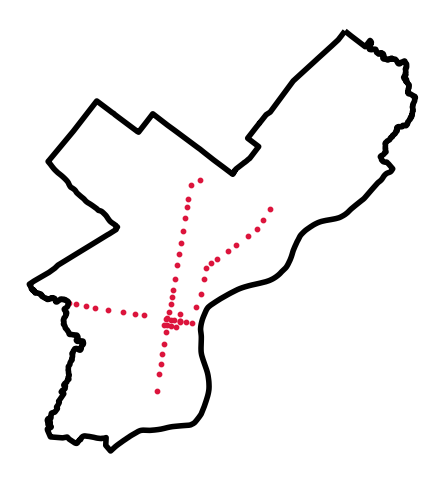

In [101]:
fig, ax = plt.subplots(figsize=(6,6))

# Plot the subway locations
subway.plot(ax=ax, markersize=10, color='crimson')

# City limits, too
city_limits.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=4)

ax.set_axis_off()

The stops on the Market-Frankford and Broad St. subway lines!

#### Now, get the distances to the nearest subway stop

We'll use k=1 to get the distance to the nearest stop.

In [102]:
# STEP 1: x/y coordinates of subway stops (in EPGS=3857)
subwayXY = get_xy_from_geometry(subway.to_crs(epsg=3857))

# STEP 2: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=1)

# STEP 3: Fit the algorithm on the "neighbors" dataset
nbrs.fit(subwayXY)

# STEP 4: Get distances for sale to neighbors
subwayDists, subwayIndices = nbrs.kneighbors(salesXY)

# STEP 5: add back to the original dataset
sales["logDistSubway"] = np.log10(subwayDists.mean(axis=1))

#### Let's plot a hex map again!

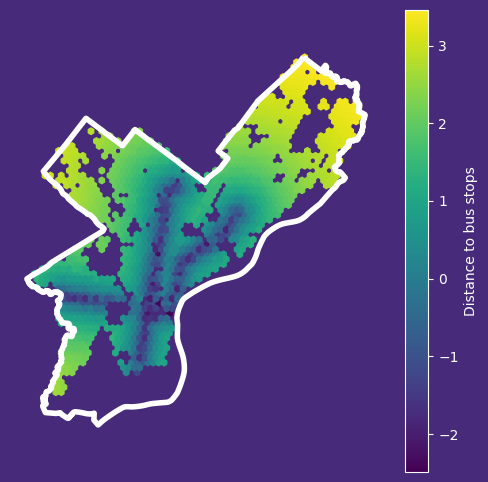

In [103]:


fig, ax = plt.subplots(figsize=(6,6), facecolor=plt.get_cmap('viridis')(30))

# Plot the log of the subway distance
x = salesXY[:,0]
y = salesXY[:,1]
ax.hexbin(x, y, C=sales['logDistSubway'].values, gridsize=60)


# Add color bar for the hexbin plot
cb = plt.colorbar(hb, ax=ax, orientation="vertical")
cb.set_label("Distance to bus stops", color="white")  # Set colorbar label to white

# Change color of the colorbar ticks
cb.ax.yaxis.set_tick_params(color="white")  # Color of tick marks
cb.ax.yaxis.set_tick_params(labelcolor="white")  # Color of tick labels

# Change the spine color of the colorbar to white
cb.outline.set_edgecolor("white")

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

# Set axis off
ax.set_axis_off()
ax.set_aspect("equal")

plt.show()


Looks like it worked!

## What about correlations?

Let's have a look at the correlations of numerical columns:

In [104]:
import seaborn as sns

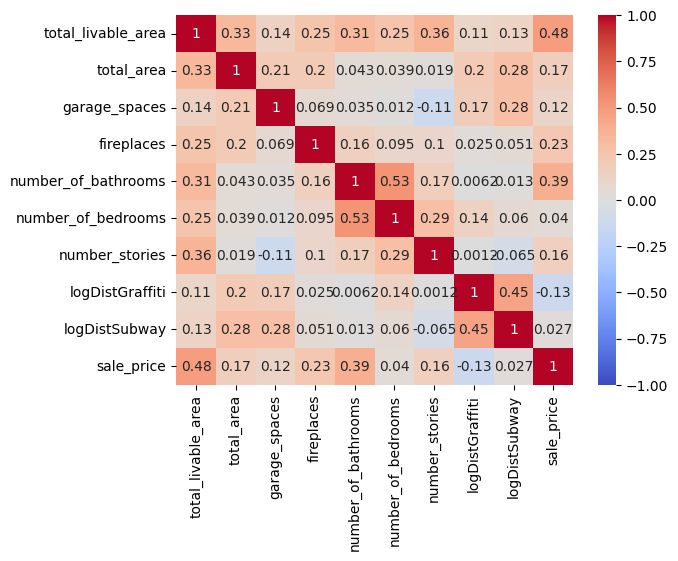

In [105]:
cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "logDistGraffiti", # NEW
    "logDistSubway",  # NEW
    "sale_price"
]
sns.heatmap(sales[cols].corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1);

## Now, let's re-run our model...did it help?

In [106]:
# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "logDistGraffiti", # NEW
    "logDistSubway" # NEW
]

# Categorical columns
cat_cols = ["exterior_condition", "zip_code"]

In [107]:
# Set up the column transformer with two transformers
transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

In [108]:
# Initialize the pipeline
# NOTE: only use 20 estimators here so it will run in a reasonable time
pipe = make_pipeline(
    transformer, RandomForestRegressor(n_estimators=20, random_state=42)
)

In [109]:
# Split the data 70/30
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

# the target labels
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

In [110]:
# Fit the training set
# REMINDER: use the training dataframe objects here rather than numpy array
pipe.fit(train_set, y_train);

In [111]:
# What's the test score?
# REMINDER: use the test dataframe rather than numpy array
pipe.score(test_set, y_test)

0.6083692791290457

### A small improvement!

R-squared of ~0.54 improved to R-squared of ~0.61

## How about the top 30 feature importances now?

In [112]:
def plot_feature_importances(pipeline, num_cols, transformer, top=20, **kwargs):
    """
    Utility function to plot the feature importances from the input
    random forest regressor.

    Parameters
    ----------
    pipeline :
        the pipeline object
    num_cols :
        list of the numerical columns
    transformer :
        the transformer preprocessing step
    top : optional
        the number of importances to plot
    **kwargs : optional
        extra keywords passed to the hvplot function
    """
    # The one-hot step
    ohe = transformer.named_transformers_["cat"]

    # One column for each category type!
    ohe_cols = ohe.get_feature_names_out()

    # Full list of columns is numerical + one-hot
    features = num_cols + list(ohe_cols)

    # The regressor
    regressor = pipeline["randomforestregressor"]

    # Create the dataframe with importances
    importance = pd.DataFrame(
        {"Feature": features, "Importance": regressor.feature_importances_}
    )

    # Sort importance in descending order and get the top
    importance = importance.sort_values("Importance", ascending=False).iloc[:top]

    # Plot
    return importance.hvplot.barh(
        x="Feature", y="Importance", flip_yaxis=True, **kwargs
    )

In [113]:
plot_feature_importances(pipe, num_cols, transformer, top=30, height=500)

/Users/delmelle/miniforge3/lib/python3.10/site-packages/hvplot/converter.py:578: ParamDeprecationWarning: 'params' has been deprecated and will be removed in a future version. Use instead `.param.values()` or `.param['param']`
  if k in OverlayPlot.param.params()}


:Bars   [Feature]   (Importance)

### Both new spatial features are in the top 5 in terms of importance!

## Exercise: How about other spatial features?

- I've listed out several other types of potential sources of new distance-based features from OpenDataPhilly
- Choose a few and add new features
- Re-fit the model and evalute the performance on the test set and feature importances

Modify the `get_xy_from_geometry()` function to use the "centroid" of the geometry column.

**Note: you can take the centroid of a Point() or Polygon() object.** For a Point(), you just get the x/y coordinates back.

In [83]:
def get_xy_from_geometry(df):
    """
    Return a numpy array with two columns, where the 
    first holds the `x` geometry coordinate and the second 
    column holds the `y` geometry coordinate
    """
    # NEW: use the centroid.x and centroid.y to support Polygon() and Point() geometries 
    x = df.geometry.centroid.x
    y = df.geometry.centroid.y
    
    return np.column_stack((x, y)) # stack as columns

### 1. Universities

New feature: Distance to the *nearest* university/college

- Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/philadelphia-universities-and-colleges)
- [GeoJSON URL](https://opendata.arcgis.com/api/v3/datasets/8ad76bc179cf44bd9b1c23d6f66f57d1_0/downloads/data?format=geojson&spatialRefId=4326)


In [117]:
# Get the data
url = "https://opendata.arcgis.com/api/v3/datasets/8ad76bc179cf44bd9b1c23d6f66f57d1_0/downloads/data?format=geojson&spatialRefId=4326"
univs = gpd.read_file(url)

univs = univs.to_crs(epsg=3857)  # Ensure the CRS is correct
univs["geometry"] = univs.centroid

# Get the X/Y
univXY = get_xy_from_geometry(univs.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(univXY)
univDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales['logDistUniv'] = np.log10(univDists.mean(axis=1))

In [118]:
print(univs.geometry.geom_type.value_counts())

Point    629
Name: count, dtype: int64


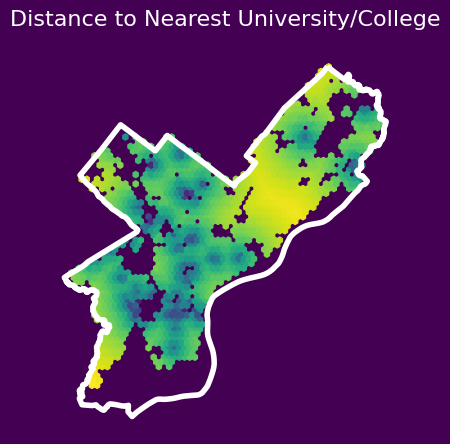

In [119]:
fig, ax = plt.subplots(figsize=(5,5), facecolor=plt.get_cmap('viridis')(0))

x = salesXY[:,0]
y = salesXY[:,1]
ax.hexbin(x, y, C=np.log10(univDists.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to Nearest University/College", fontsize=16, color='white');

### 2. Parks

New feature: Distance to the *nearest* park centroid

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/ppr-properties)
* [GeoJSON URL](https://opendata.arcgis.com/datasets/d52445160ab14380a673e5849203eb64_0.geojson)

**Notes** 
- The park geometries are *polygons*, so you'll need to get the `x` and `y` coordinates of the park *centroids* and calculate the distance to these centroids. 
- You can use the `geometry.centroid.x` and `geometry.centroid.y` values to access these coordinates.

In [121]:
# Get the data
url = "https://opendata.arcgis.com/datasets/d52445160ab14380a673e5849203eb64_0.geojson"
parks = gpd.read_file(url)

parks = parks.to_crs(epsg=3857)  # Ensure the CRS is correct
parks["geometry"] = parks.centroid

# Get the X/Y
parksXY = get_xy_from_geometry(parks.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(parksXY)
parksDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistParks"] = np.log10(parksDists.mean(axis=1))

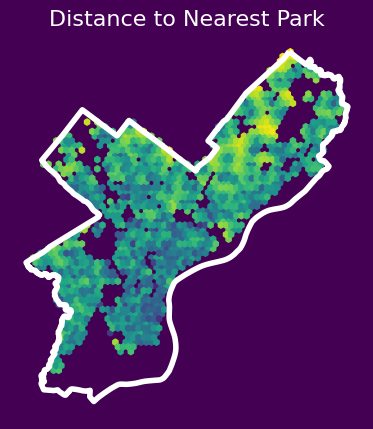

In [122]:
fig, ax = plt.subplots(figsize=(5, 5), facecolor=plt.get_cmap("viridis")(0))

x = salesXY[:, 0]
y = salesXY[:, 1]
ax.hexbin(x, y, C=np.log10(parksDists.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to Nearest Park", fontsize=16, color="white");

### 3. Residential Construction Permits

New feature: Distance to the 5 nearest residential construction permits from 2022

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/licenses-and-inspections-building-permits)
* CARTO table name: "permits"


**Notes**

* You can pull new construction permits only by selecting where `permitdescription` equals 'RESIDENTRIAL CONSTRUCTION PERMIT'
* You can select permits from only 2022 using the `permitissuedate` column

In [132]:
# Table name
table_name = "permits"

# Where clause
where = "permitissuedate >= '2022-01-01' AND permitissuedate < '2023-01-01'"
where = where + " AND permitdescription='RESIDENTIAL BUILDING PERMIT'"

# Query
permits = get_carto_data(table_name, where=where)

# Remove missing
not_missing = ~permits.geometry.is_empty & permits.geometry.notna()
permits = permits.loc[not_missing]

# Get the X/Y
permitsXY = get_xy_from_geometry(permits.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(permitsXY)
permitsDist, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistPermits"] = np.log10(permitsDist.mean(axis=1))

/var/folders/lv/8xb4hscx2hs0c0fwhd2bnjy80000gn/T/ipykernel_5039/3972340687.py:12: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  not_missing = ~permits.geometry.is_empty & permits.geometry.notna()


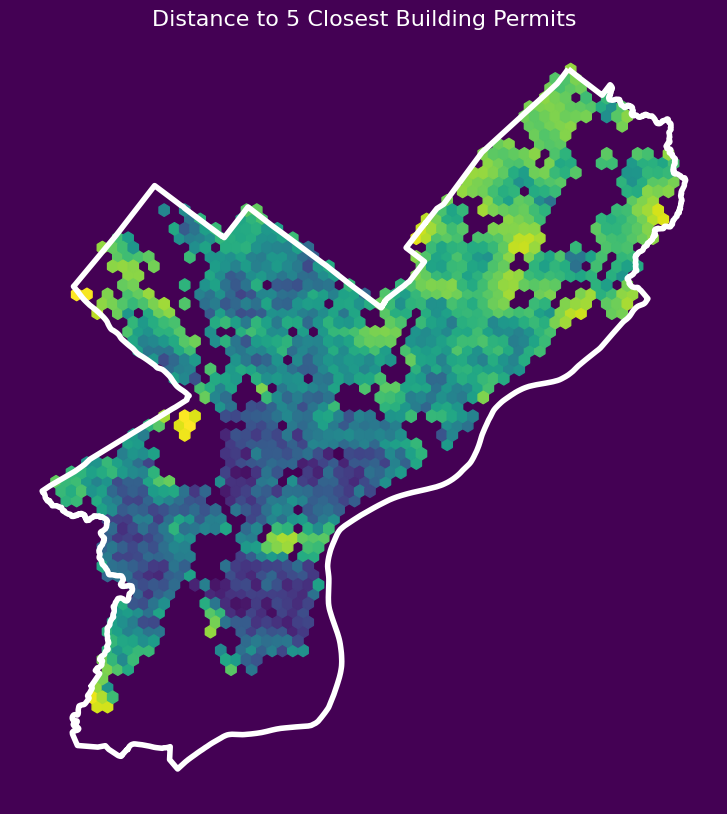

In [133]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor=plt.get_cmap("viridis")(0))

x = salesXY[:, 0]
y = salesXY[:, 1]
ax.hexbin(x, y, C=np.log10(permitsDist.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to 5 Closest Building Permits", fontsize=16, color="white");

### 4. Aggravated Assaults

New feature: Distance to the 5 nearest aggravated assaults in 2022

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/crime-incidents)
* CARTO table name: "incidents_part1_part2"

**Notes**

* You can pull aggravated assaults only by selecting where `Text_General_Code` equals 'Aggravated Assault No Firearm' or 'Aggravated Assault Firearm'
* You can select crimes from only 2022 using the `dispatch_date` column

In [134]:
# Table name
table_name = "incidents_part1_part2"

# Where selection
where = "dispatch_date >= '2022-01-01' AND dispatch_date < '2023-01-01'"
where = where + " AND Text_General_Code IN ('Aggravated Assault No Firearm', 'Aggravated Assault Firearm')"

# Query
assaults = get_carto_data(table_name, where=where)

# Remove missing 
not_missing = ~assaults.geometry.is_empty & assaults.geometry.notna()
assaults = assaults.loc[not_missing]
    
# Get the X/Y
assaultsXY = get_xy_from_geometry(assaults.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(assaultsXY)
assaultDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales['logDistAssaults'] = np.log10(assaultDists.mean(axis=1))

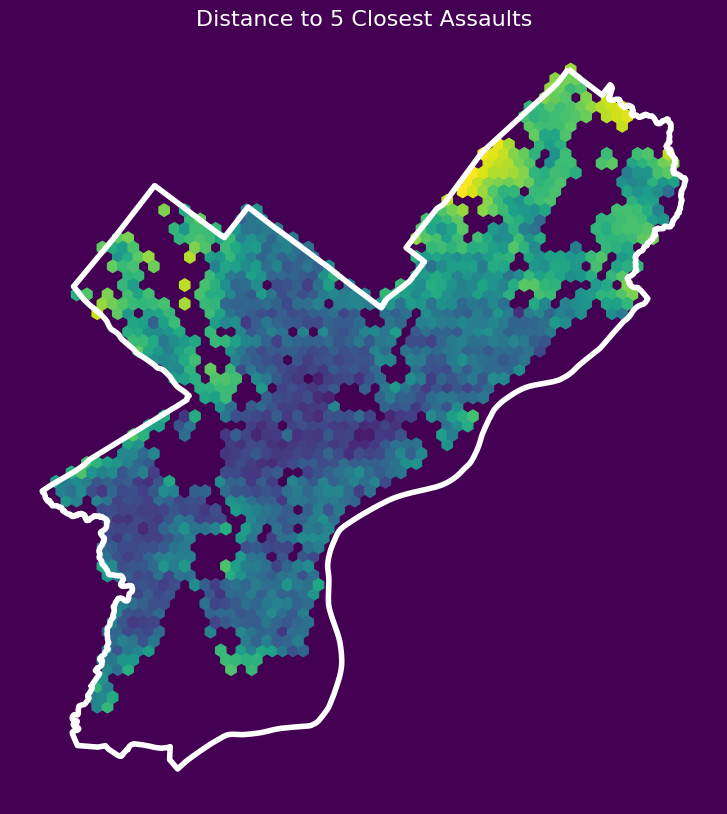

In [135]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor=plt.get_cmap("viridis")(0))

x = salesXY[:, 0]
y = salesXY[:, 1]
ax.hexbin(x, y, C=np.log10(assaultDists.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to 5 Closest Assaults", fontsize=16, color="white");

### 5. Abandonded Vehicle 311 Calls

New feature: Distance to the 5 nearest abandoned vehicle 311 calls in 2022

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/311-service-and-information-requests)
* CARTO table name: "public_cases_fc"

**Notes**

* You can pull abandonded vehicle calls only by selecting where `service_name` equals 'Abandoned Vehicle'
* You can select crimes from only 2022 using the `requested_datetime` column

In [136]:
# Table name
table_name = "public_cases_fc"

# Where selection
where = "requested_datetime >= '2022-01-01' AND requested_datetime < '2023-01-01'"
where = "service_name = 'Abandoned Vehicle'"

# Query
cars = get_carto_data(table_name, where=where)

# Remove missing
not_missing = ~cars.geometry.is_empty & cars.geometry.notna()
cars = cars.loc[not_missing]

# Get the X/Y
carsXY = get_xy_from_geometry(cars.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(carsXY)
carDists, _ = nbrs.kneighbors(salesXY)

# Handle any sales that have 0 distances
carDists[carDists == 0] = 1e-5  # a small, arbitrary value

# Add the new feature
sales["logDistCars"] = np.log10(carDists.mean(axis=1))

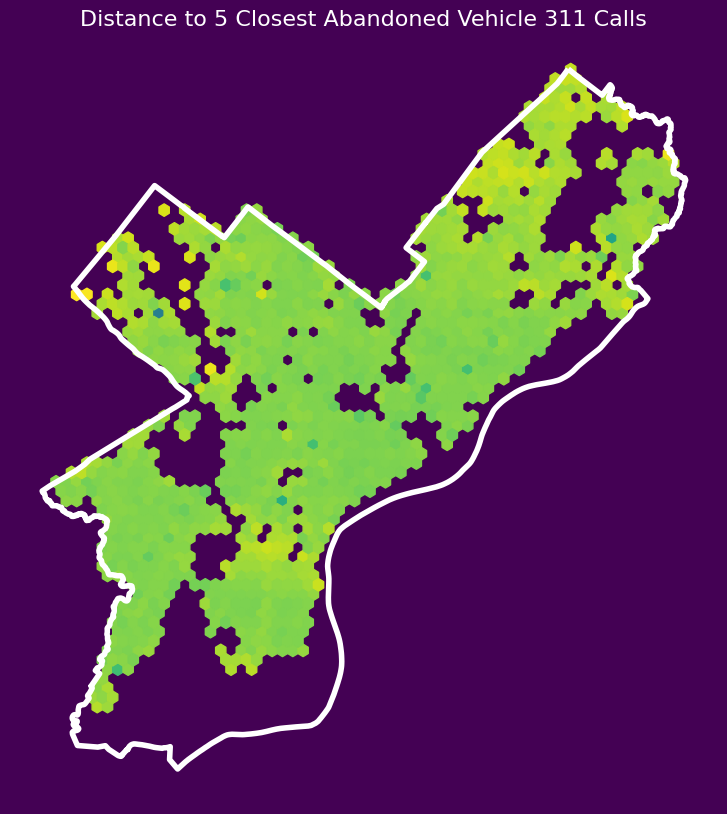

In [137]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor=plt.get_cmap("viridis")(0))

x = salesXY[:, 0]
y = salesXY[:, 1]
ax.hexbin(x, y, C=np.log10(carDists.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title(
    "Distance to 5 Closest Abandoned Vehicle 311 Calls", fontsize=16, color="white"
);

### 6. City Hall

New feature: Distance to City Hall.

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/city-landmarks)
* [GeoJSON URL](http://data-phl.opendata.arcgis.com/datasets/5146960d4d014f2396cb82f31cd82dfe_0.geojson)

**Notes**

- To identify City Hall, you'll need to pull data where "NAME='City Hall'" and "FEAT_TYPE='Municipal Building'"
- As with the parks, the geometry will be a *polygon*, so you should calculate the distance to the *centroid* of the City Hall polygon
- url = "http://data-phl.opendata.arcgis.com/datasets/5146960d4d014f2396cb82f31cd82dfe_0.geojson"
landmarks = gpd.read_file(url)


### 7. SEPTA train stations
- identify if a house is close to a septa station (maybe here we don't need to get the average distance to the 5 nearest)

### 8. Bus stops
- Is the price of the house going to increase if you have more bustops nearby?